In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

numpy   1.18.4
seaborn 0.10.1
pandas  1.0.4



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import pandas as pd
import requests

from io import StringIO

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1xqhFLsQplNUu5k9Uxv7DgTwftCiE78E0JmsKvNi0Ft4/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"

In [4]:
dd = defaultdict(set)
dd_species = defaultdict(set)
for t in df_truth.itertuples():
    query = t.homotypic_synonym
    results = !rg {query} {inf_tax_file}
    if len(results) > 0:
        for r in results:
            split = r.split("\t")
            dd[t.dataset].add(split[0])
            dd_species[t.dataset].add(";".join(split[1].split(";")[:7]))

# Building the true species dataset

In [5]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

In [6]:
from glob import glob
import os

basepath = "/mnt/btrfs/data/type_1/species_mc"
dirs = [d for d in os.listdir(basepath) if os.path.isdir(os.path.join(basepath, d))]

# dual_index failed
dirs.remove('dual_index')

In [7]:
dfs = []
for directory in dirs:
    df = pd.read_csv(os.path.join(basepath, directory, 'filter', 't1.coverage.r202.txt'), index_col = 0)
    df['dataset'] = directory
    dfs.append(df)
    
df_type_1_features = pd.concat(dfs)

In [8]:
dfs = []
for directory in dirs:
    df = pd.read_csv(os.path.join(basepath, directory, 'filter', 'shogun.capitalist.r202.txt'), index_col = None, sep="\t")
    cols = list(df.columns)
    cols[0] = "tax"
    cols[1] = "hits"
    df.columns = cols

    df = df.loc[:, df.columns.difference(cols[2:])]
    df["dataset"] = directory
    df["relative_abundace"] = df.hits / df.hits.sum()
    dfs.append(df)    
df_capitalist_species = pd.concat(dfs)
df_capitalist_species["species"] = [";".join(_.split(";")[:7]) for _ in df_capitalist_species.tax]

In [9]:
rows = []
for t in df_type_1_features.itertuples():
    if t.assembly_accession in dd[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [10]:
rows = []
for t in df_capitalist_species.itertuples():
    if t.species in dd_species[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_capitalist_species["truth"] = rows

In [11]:
df_capitalist_species

,hits,tax,dataset,relative_abundace,species,truth
0,224118,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,hmp_even,2.907763e-02,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,True
1,548005,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,hmp_even,7.109954e-02,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,True
2,38202,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,hmp_even,4.956423e-03,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,True
3,96185,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,hmp_even,1.247928e-02,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,False
4,1562766,k__Bacteria;p__Deinococcus-Thermus;c__Deinococ...,hmp_even,2.027572e-01,k__Bacteria;p__Deinococcus-Thermus;c__Deinococ...,True
...,...,...,...,...,...,...
7349,1,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,mbarc_26,1.252560e-08,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,False
7350,2,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,mbarc_26,2.505119e-08,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,False
7351,1,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,mbarc_26,1.252560e-08,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,False
7352,1,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,mbarc_26,1.252560e-08,k__Bacteria;p__Verrucomicrobia;c__Opitutae;o__...,False


In [12]:
df_type_1_features.groupby('dataset').sum()

,hits,percent_coverage,expected_coverage,percent_padded_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,genome_length,num_n_groups,consecutive_ns,truth
dataset,,,,,,,,,,,,
gis_20,216722326,inf,1231.046805,3.948053e+14,25.422992,6398.396344,9790703,4764.585069,40282278047,577600,3736705,19.0
hmp_even,21118721,inf,208.360791,1.915991e+14,107.570299,6171.411861,726120,6009.470874,49721569127,698077,9176602,22.0
hmp_staggered,9307335,inf,97.395849,3.600733e+14,74.670076,6630.882502,335811,5294.683951,43610143799,623232,8819796,22.0
mbarc_26,79836517,inf,110.211152,3.352368e+14,60.476158,5500.880836,459500,3959.278986,32165708279,484208,7432059,27.0
zymo_even,8494708,inf,103.554600,1.447779e+14,28.516582,3327.315691,237969,2301.786497,18957018043,288448,2067192,9.0
zymo_log,62941112,inf,425.291465,2.999574e+14,3.546478,5512.373119,4169900,3641.537681,29445668604,416747,7250367,9.0


In [13]:
df_type_1_features[~np.isfinite(df_type_1_features['shannon_entropy'])]

,assembly_accession,hits,percent_coverage,expected_coverage,percent_padded_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,genome_length,num_n_groups,consecutive_ns,dataset,truth
1,GCF_002934005.1,8200,5.519637e+09,0.120160,3.592328e+09,NaN,0.616358,359,0.376704,4542898,303,214,hmp_even,False
2,GCF_900097965.1,22946,4.094000e+08,0.444941,2.163046e+08,NaN,0.109384,458,0.332985,2708739,40,20,hmp_even,False
3,GCF_007682245.1,18518,3.093279e+08,0.403710,1.782450e+08,NaN,0.216303,450,0.387903,2480492,23,99,hmp_even,False
6,GCF_001558215.1,433454,2.115599e+06,1.000000,2.067912e+06,NaN,0.008497,243,0.368948,1984441,0,0,hmp_even,True
7,GCF_006094375.1,1324294,2.584484e+06,1.000000,2.556085e+06,NaN,0.006573,3091,0.322196,2491058,2,20,hmp_even,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,GCF_000576305.1,24,3.108519e+10,0.000445,1.363960e+10,NaN,0.341086,11,0.420244,4961801,67,20,mbarc_26,False
3687,GCF_000425665.1,16,2.448981e+10,0.000738,9.501513e+09,NaN,0.999924,14,0.289823,1864820,39,1071,mbarc_26,False
3736,GCF_008831385.1,75,2.198359e+09,0.003559,1.004011e+09,NaN,0.440453,12,0.381610,1836976,0,0,mbarc_26,False
3748,GCF_900120125.1,38,5.857219e+09,0.002092,2.448582e+09,NaN,0.903181,17,0.305431,1804609,7,196,mbarc_26,False


In [14]:
df_type_1_features[~np.isfinite(df_type_1_features['percent_coverage'])]

,assembly_accession,hits,percent_coverage,expected_coverage,percent_padded_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,genome_length,num_n_groups,consecutive_ns,dataset,truth
503,GCF_000185505.1,548,inf,0.0,5.415995e+10,-0.0,2.0,0,0.516341,2327229,74,3591,hmp_even,False
1690,GCF_000377665.1,50,inf,0.0,1.645755e+11,-0.0,2.0,0,0.545081,4056790,17,1572,hmp_even,False
2186,GCF_003208175.1,28,inf,0.0,1.929096e+11,-0.0,2.0,0,0.386972,4392147,73,1571,hmp_even,False
2725,GCF_000621505.1,77,inf,0.0,3.749797e+11,-0.0,2.0,0,0.413760,6123559,93,2414,hmp_even,False
4013,GCF_000521175.1,459,inf,0.0,3.229079e+11,-0.0,2.0,0,0.384763,5682499,337,4276,hmp_even,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,GCF_000295095.1,1,inf,0.0,8.485884e+10,-0.0,2.0,0,0.711984,2913054,39,1638,mbarc_26,False
7195,GCF_000185445.1,1,inf,0.0,4.356074e+10,-0.0,2.0,0,0.556235,2087121,14,5142,mbarc_26,False
7258,GCF_000312125.1,1,inf,0.0,8.919809e+10,-0.0,2.0,0,0.614291,2986605,77,862,mbarc_26,False
7284,GCF_000269805.1,1,inf,0.0,1.121277e+11,-0.0,2.0,0,0.677748,3348548,34,2158,mbarc_26,False


In [15]:
X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

y = X_type_1["truth"]
X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]


X_type_1_train, X_type_1_test, y_train, y_test = train_test_split(X_type_1, y, random_state=42)

               consecutive_ns  expected_coverage   gc_content  genome_length  \
dataset                                                                        
gis_20                3556705        1231.046805  4720.034192    39854697955   
hmp_even              9060467         208.360791  5988.285223    49545487763   
hmp_staggered         8417488          97.395849  5256.079313    43301611448   
mbarc_26              7226813         110.211152  3906.507494    31746415847   
zymo_even             1950228         103.554600  2276.009731    18752766442   
zymo_log              6990677         425.291465  3585.870711    29008414385   

                    hits  largest_pileup  num_n_groups  percent_coverage  \
dataset                                                                    
gis_20         216697348         9790703        568298      9.616551e+14   
hmp_even        21116053          726120        694519      6.914596e+14   
hmp_staggered    9305486          335811        613934 

In [16]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_type_1_train, y_train)

RandomForestClassifier(random_state=42)

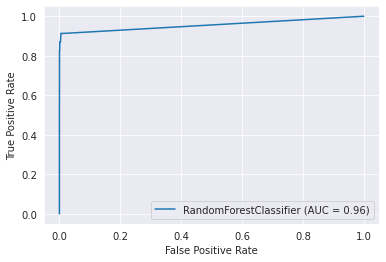

In [17]:
clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
plt.show()

In [18]:
# X_type_1["truth"] = y
# sns.pairplot(X_type_1, hue="truth")

In [19]:
# explainer = shap.TreeExplainer(clf, X_type_1_train)

# shap_values = explainer.shap_values(X_type_1_train)
# shap.summary_plot(shap_values, X_type_1_train, show=False)
# fig = plt.gcf()

In [20]:
y_preds = clf.predict(X_type_1)

accuracy = (y_preds == y).sum() / (y.shape[0])

print(accuracy)

0.9997765771621238


In [21]:
y_preds.sum()

101

In [22]:
y.sum()

108

In [23]:
X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

               consecutive_ns  expected_coverage   gc_content  genome_length  \
dataset                                                                        
gis_20                3556705        1231.046805  4720.034192    39854697955   
hmp_even              9060467         208.360791  5988.285223    49545487763   
hmp_staggered         8417488          97.395849  5256.079313    43301611448   
mbarc_26              7226813         110.211152  3906.507494    31746415847   
zymo_even             1950228         103.554600  2276.009731    18752766442   
zymo_log              6990677         425.291465  3585.870711    29008414385   

                    hits  largest_pileup  num_n_groups  percent_coverage  \
dataset                                                                    
gis_20         216697348         9790703        568298      9.616551e+14   
hmp_even        21116053          726120        694519      6.914596e+14   
hmp_staggered    9305486          335811        613934 

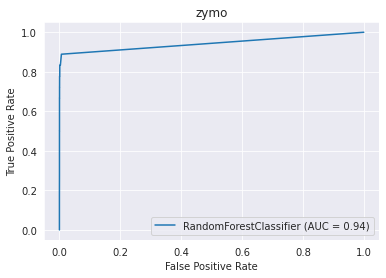

Precision: 0.8
Recall: 0.4
Precision Capitalist: 0.3448275862068966
Recall Capitalist: 0.5


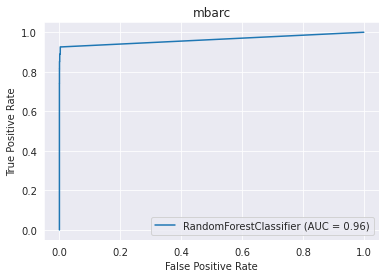

Precision: 0.9166666666666666
Recall: 0.8461538461538461
Precision Capitalist: 0.8888888888888888
Recall Capitalist: 0.6153846153846154


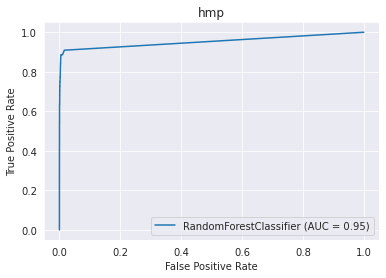

Precision: 0.7714285714285715
Recall: 0.6136363636363636
Precision Capitalist: 0.4318181818181818
Recall Capitalist: 0.4318181818181818


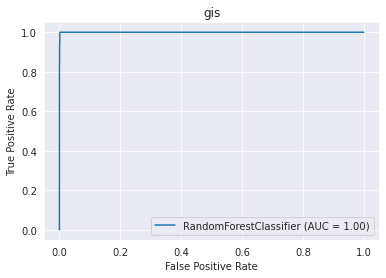

Precision: 0.8888888888888888
Recall: 0.8
Precision Capitalist: 0.4583333333333333
Recall Capitalist: 0.55


In [24]:
ra_mask = df_capitalist_species["relative_abundace"] > .005

df_c_ra = df_capitalist_species[ra_mask]

for dataset in ["zymo", "mbarc", "hmp", "gis"]:
    
    X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
    X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
    X_type_1 = X_type_1.dropna()
    
    mask_dataset = np.array([_.startswith(dataset) for _ in X_type_1["dataset"]])

    y = X_type_1["truth"]
    X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]
    
    X_type_1_train = X_type_1.loc[~mask_dataset, :]
    X_type_1_test =  X_type_1.loc[mask_dataset, :]
    y_train = y.loc[~mask_dataset]
    y_test = y.loc[mask_dataset]
    
    clf = RandomForestClassifier(random_state=42)

    clf.fit(X_type_1_train, y_train)
    
    
    clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
    plt.title(dataset)
    plt.show()
    
    y_test_preds = clf.predict(X_type_1_test)
    
    precision = y_test[y_test_preds].sum() / y_test_preds.sum()
    
    print("Precision:", precision)
    
    recall = y_test[y_test_preds].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
    print("Recall:", recall)
    
    mask_ra = df_c_ra["dataset"].str.startswith(dataset)
    
    df_masked = df_c_ra.loc[mask_ra, :]
    
    precision_cap = df_masked["truth"].sum() / df_masked.shape[0]
    
    print("Precision Capitalist:", precision_cap)
    
    recall_cap = df_masked["truth"].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
    print("Recall Capitalist:", recall_cap)